# Objective

You have access to training data on ~25k loan applications, and the ~80k payments made against those loans.

Your goal is to use that data to build a model that would be able to predict the performance of 2,000 loans that are currently in Due Diligence (the test data).

> Notes
> - None of the 2,000 loans in Due Diligence are first time applicants.  They are all from businesses that have previously received at least one loan from Numida.  The data on their previous loans is in the training data set.
> - There is no predetermined target variable or definition of good performance - you are encouraged to come up with your own.  That being said, this is how Numida generally thinks about performance
>     - Customers that repay on-time are more likely to be retained which is good for our business
>     - It’s rare for us to relend to a customer that pays back more than 15 days late
>     - Ultimately, yield is one of our most important metrics
> - We generally expect 5% - 10% of loans to be written off

## Requirements

1. **Tools and Technologies**
    - Use Python to implement the solution.
    - You may use Jupyter Notebook if desired.

2. **Clearly defined target variable**
   - Clearly defined target variable and explanation for the choice.
   - Include any assumptions about the problem or data that you make.

3. **A process for training a model that another analyst or engineer could replicate without too much troublet**

4. **The approach should be able to handle the addition of new input variables gracefully**

5. **A list of steps you would take next**

## Bonus

- Training and validating your model (or making predictions) against the 2,000 loans in the test data.
    - This part of the assignment is primarily to provide context and help explain the nature of the challenges faced by Numida
- Note down additional suggestions, given more time

# 📝 | Notes
- Found and removed 1723 duplicated rows in train_loan_data. What causes this?
- train_payment_data has duplicated rows too. Add to preprocessing pipeline.
- Account for only unique instances considering either business_id, loan_id or applying numbers.
- payment_status column is missing

# 📚 | Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# ⚙️ | Utilities

In [2]:
# Implemented in utils
import eda_utils as utils
import warnings
warnings.filterwarnings('ignore')

# 📁 | Data

In [3]:
data_dir = Path.cwd()/"machine-learning/"
utils.print_folder_tree(data_dir)

├── train_loan_data.csv
├── test_loan_data.csv
├── README.md
├── logo.numida.png
├── train_payment_data.csv
└── .ipynb_checkpoints
    └── README-checkpoint.md


## Descriptions

### train_loan_data.csv
- These are all the loans previously taken by the 2,000 customers that currently have a loan application in due diligence
- There are around 25,000 loans

In [4]:
# Read in the data.
train_loan_data = pd.read_csv(data_dir/"train_loan_data.csv")

In [5]:
# Get a feel of the data.
train_loan_data.sample(3)

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
6584,886238,9027,395019.0,NaN,Friend,Beauty Fashion,2000000.0,2239000.0,34,33,33.0,1.0,Approved,False,2239000.0,2239000.0,239000.0
9152,929498,327313,279290.0,NaN,Friend,Repairs Cleaning,410300.0,460000.0,16,16,16.0,1.0,Approved,False,460000.0,460000.0,49700.0
23102,479761,239663,260477.0,NaN,Friend,Autoparts Hardware,478900.0,532300.0,8,8,8.0,2.0,Approved,False,532300.0,532300.0,53400.0


**Process Duplicates**

In [6]:
# Any duplicated data? Remove it.
train_loan_data[train_loan_data.duplicated(keep=False)].query("loan_id == 400947")

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
23826,400947,210364,320438.0,NaN,Friend,Autoparts Hardware,749300.0,832700.0,7,7,7.0,5.0,Approved,False,832700.0,832700.0,83400.0
23852,400947,210364,320438.0,NaN,Friend,Autoparts Hardware,749300.0,832700.0,7,7,7.0,5.0,Approved,False,832700.0,832700.0,83400.0
23880,400947,210364,320438.0,NaN,Friend,Autoparts Hardware,749300.0,832700.0,7,7,7.0,5.0,Approved,False,832700.0,832700.0,83400.0


In [7]:
train_loan_data = train_loan_data.drop_duplicates(ignore_index=True)

In [8]:
train_loan_data.query("loan_id == 400947")

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
22234,400947,210364,320438.0,NaN,Friend,Autoparts Hardware,749300.0,832700.0,7,7,7.0,5.0,Approved,False,832700.0,832700.0,83400.0


In [9]:
# State of missing values, data types.
train_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23379 entries, 0 to 23378
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   23379 non-null  int64  
 1   business_id               23379 non-null  int64  
 2   credit_officer_id         22954 non-null  float64
 3   dismissal_description     515 non-null    object 
 4   acquisition_channel       23379 non-null  object 
 5   sector                    23379 non-null  object 
 6   principal                 23379 non-null  float64
 7   total_owing_at_issue      22307 non-null  float64
 8   application_number        23379 non-null  int64  
 9   applying_for_loan_number  23379 non-null  int64  
 10  loan_number               22307 non-null  float64
 11  employee_count            22566 non-null  float64
 12  approval_status           23379 non-null  object 
 13  paid_late                 23379 non-null  bool   
 14  total_

In [10]:
# Number of unique loans? What data is contained in the other 1723 instances?
train_loan_data.loan_id.nunique()

23379

In [11]:
# Number of unique business?
train_loan_data.business_id.nunique()

1869

In [12]:
# Number of unique credit officers?
train_loan_data.credit_officer_id.nunique()

82

In [13]:
# Number of unique acquisition channels?
train_loan_data.acquisition_channel.nunique(), train_loan_data.acquisition_channel.unique()

(11,
 array(['Friend', 'Sales Team', 'Facebook', 'Google',
        'Radio / TV / Newspaper', 'Other', 'Numida staff', 'Instagram',
        'Twitter', 'rocket_health', 'Macro Influencer'], dtype=object))

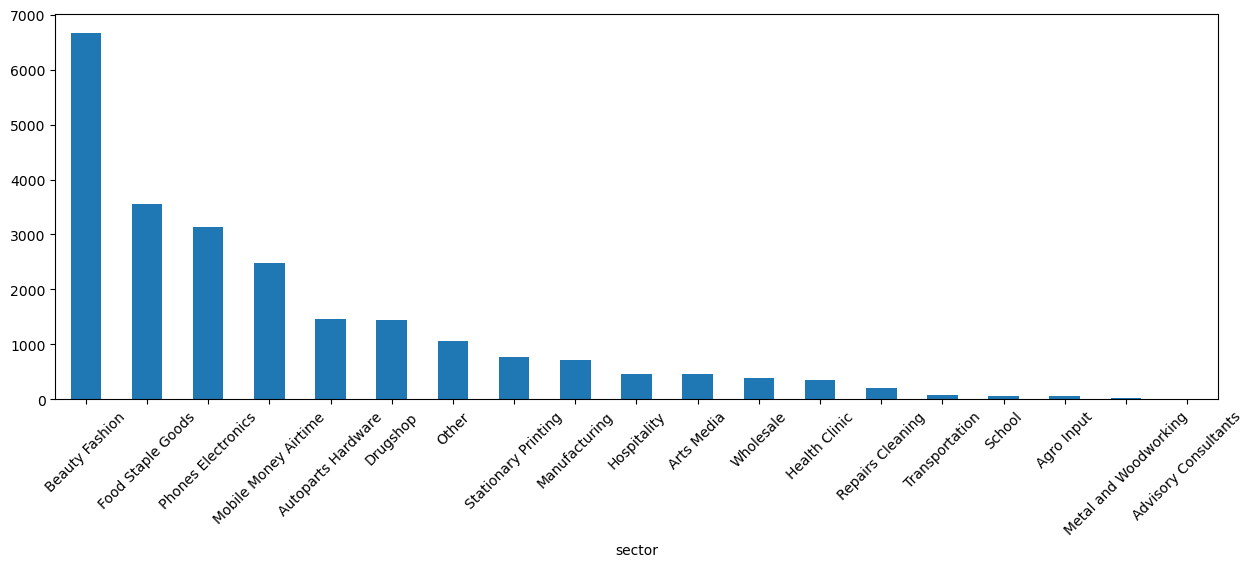

In [14]:
# Number of unique sectors?
train_loan_data.sector.value_counts().plot(kind='bar', rot=45, figsize=(15,5))
utils.plt.show()

In [15]:
# Late payements, most loans where paid on time, class imbalance problem.
train_loan_data.paid_late.value_counts()

paid_late
False    22712
True       667
Name: count, dtype: int64

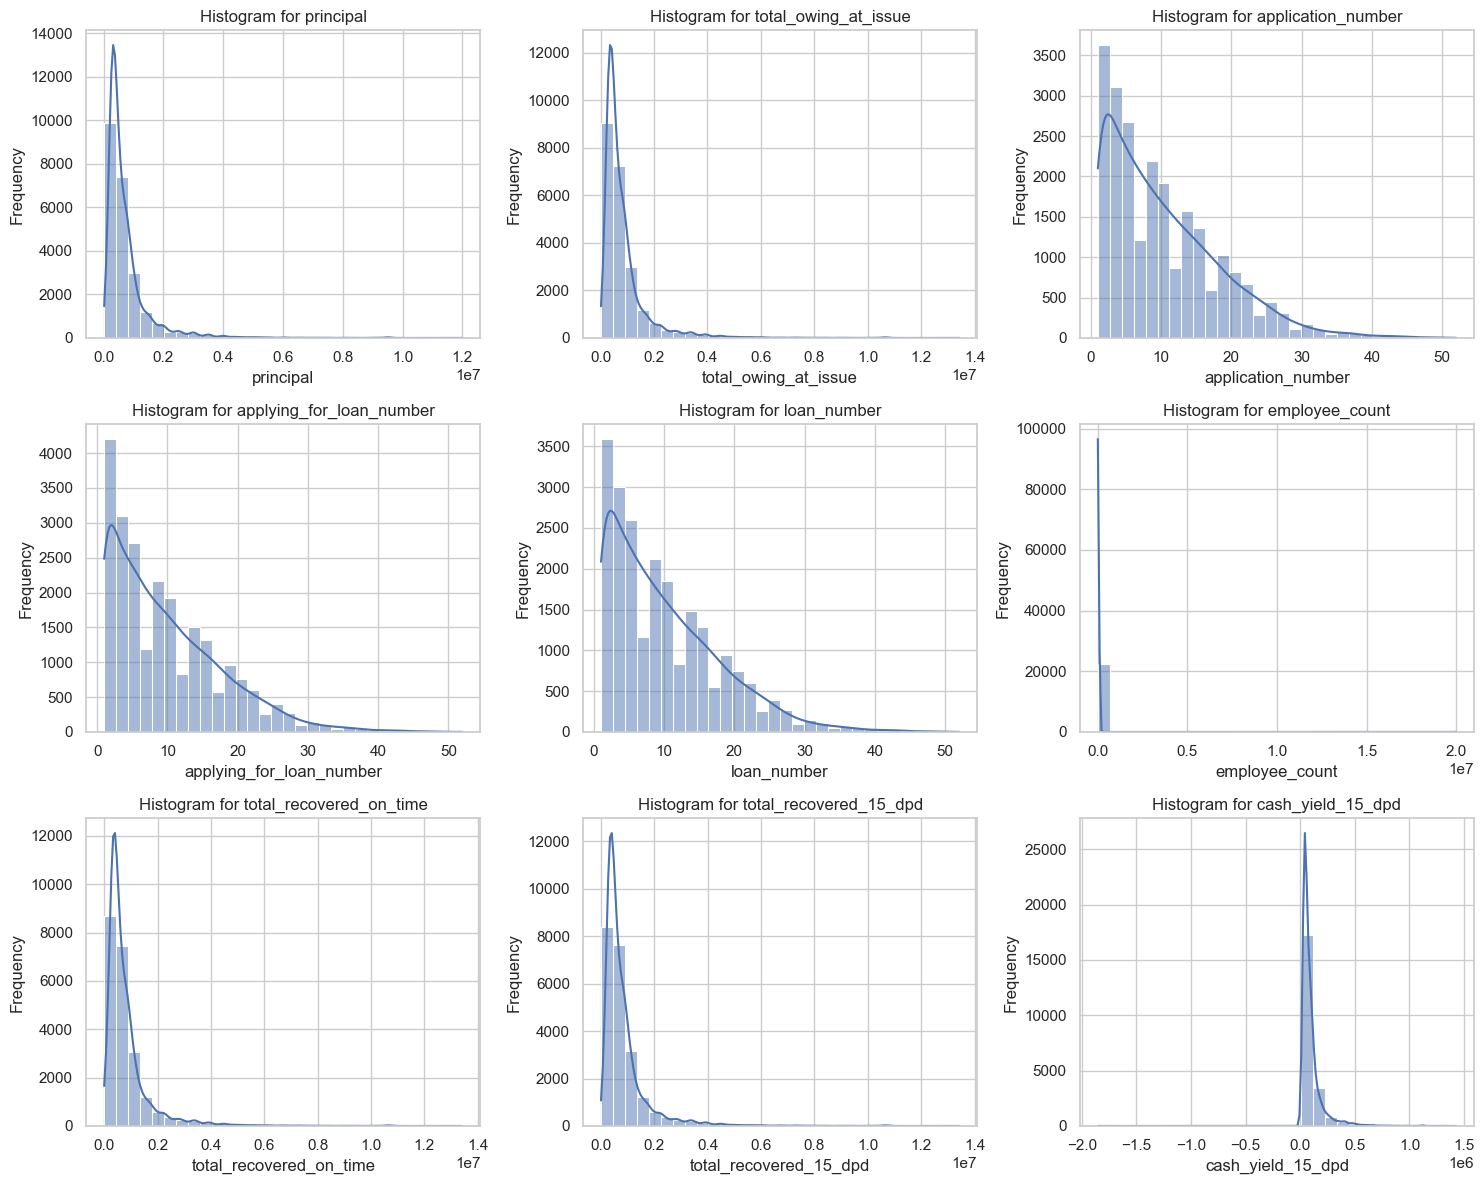

In [16]:
utils.plot_histograms(train_loan_data, skip_columns=['loan_id', 'business_id', 'credit_officer_id'])

In [17]:
# Employee count? Two businesses with 10,000 and 2M employees? Outliers?
train_loan_data.employee_count.describe()

count    2.256600e+04
mean     1.069599e+04
std      4.610967e+05
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+07
Name: employee_count, dtype: float64

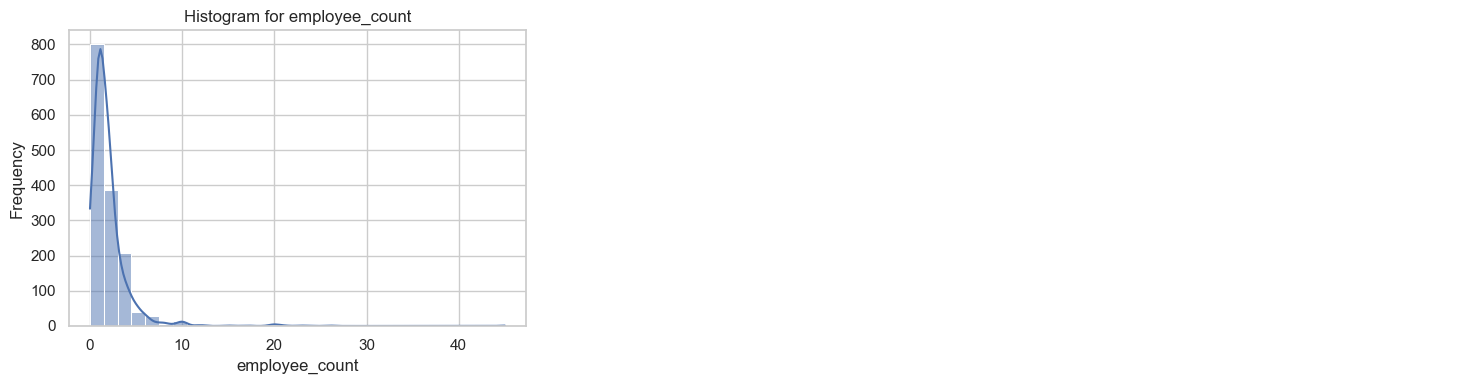

In [18]:
utils.plot_histograms(
    train_loan_data.drop_duplicates(subset=['business_id', 'employee_count'])[['employee_count']].query("employee_count < 50.0")
)

In [19]:
# train_loan_data.query("employee_count > 9000")

In [20]:
train_loan_data.approval_status.value_counts()

approval_status
Approved     22307
Declined       406
Expired        380
Cancelled      286
Name: count, dtype: int64

In [21]:
train_loan_data.query("loan_id == 745392")

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
15594,745392,447358,279289.0,NaN,Facebook,Other,435700.0,487600.0,8,8,8.0,2.0,Approved,False,487600.0,487600.0,51900.0


In [22]:
train_loan_data.query("business_id == 447358")

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
15587,628019,447358,306028.0,NaN,Facebook,Other,200000.0,223800.0,1,1,1.0,2.0,Approved,False,223800.0,223800.0,23800.0
15588,640849,447358,306028.0,NaN,Facebook,Other,207700.0,232500.0,2,2,2.0,2.0,Approved,False,232500.0,232500.0,24800.0
15589,654580,447358,279289.0,NaN,Facebook,Other,219100.0,245200.0,3,3,3.0,2.0,Approved,False,245200.0,245200.0,26100.0
15590,663006,447358,279289.0,NaN,Facebook,Other,225700.0,252600.0,4,4,4.0,2.0,Approved,False,252600.0,252600.0,26900.0
15591,686034,447358,279289.0,NaN,Facebook,Other,244400.0,273500.0,5,5,5.0,2.0,Approved,False,273500.0,273500.0,29100.0
15592,707586,447358,279289.0,NaN,Facebook,Other,291200.0,325800.0,6,6,6.0,2.0,Approved,False,325800.0,325800.0,34600.0
15593,725493,447358,279289.0,NaN,Facebook,Other,368200.0,412000.0,7,7,7.0,2.0,Approved,False,412000.0,412000.0,43800.0
15594,745392,447358,279289.0,NaN,Facebook,Other,435700.0,487600.0,8,8,8.0,2.0,Approved,False,487600.0,487600.0,51900.0
15595,768770,447358,279289.0,NaN,Facebook,Other,471900.0,529000.0,9,9,9.0,2.0,Approved,False,529000.0,529000.0,57100.0
15596,790694,447358,279289.0,NaN,Facebook,Other,509600.0,571300.0,10,10,10.0,2.0,Approved,False,571300.0,571300.0,61700.0


In [23]:
train_loan_data.query("approval_status == 'Declined'")['business_id'].value_counts().head()

business_id
124851    9
92115     6
105037    5
25158     5
123659    5
Name: count, dtype: int64

### train_payment_data.csv
- These are all the payments made against the loans in the training loan data
- Customers are encouraged to make payments throughout their loan (rather than relying on a singular payment at the end), though this is not a requirement

In [24]:
train_payment_data = pd.read_csv(data_dir/"train_payment_data.csv", parse_dates=['paid_at'])
train_payment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83275 entries, 0 to 83274
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   loan_id           83275 non-null  int64         
 1   paid_at           83275 non-null  datetime64[ns]
 2   amount            83275 non-null  float64       
 3   transaction_type  79953 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.5+ MB


In [25]:
# Remove deduplicated rows.
train_payment_data.duplicated().sum()

35

In [26]:
train_payment_data[train_payment_data.duplicated(keep=False)].query("loan_id == 162120")

,loan_id,paid_at,amount,transaction_type
4517,162120,2022-02-21 07:59:00,25000.0,Deposit
4518,162120,2022-02-21 07:59:00,25000.0,Deposit


In [27]:
train_payment_data = train_payment_data.drop_duplicates(ignore_index=True)

In [28]:
train_payment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83240 entries, 0 to 83239
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   loan_id           83240 non-null  int64         
 1   paid_at           83240 non-null  datetime64[ns]
 2   amount            83240 non-null  float64       
 3   transaction_type  79919 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.5+ MB


In [29]:
train_payment_data['transaction_type'].value_counts()

transaction_type
Deposit     78183
Discount     1736
Name: count, dtype: int64

<Axes: >

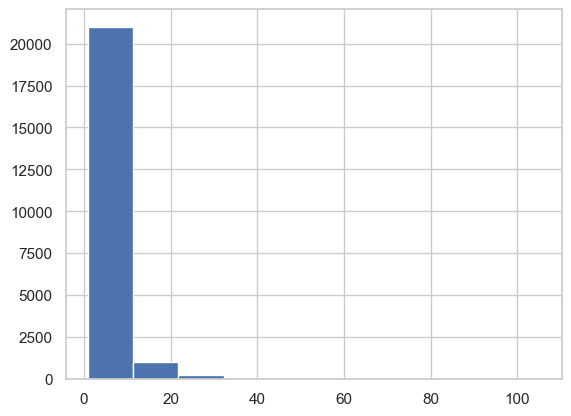

In [30]:
train_payment_data.loan_id.value_counts().hist()

In [31]:
train_payment_data.loan_id.value_counts().value_counts(normalize=True)[:5]

count
1    0.412408
2    0.164694
3    0.101623
4    0.075668
5    0.056392
Name: proportion, dtype: float64

In [32]:
train_payment_data.loan_id.nunique(), train_loan_data.loan_id.nunique()

(22308, 23379)

### Loans with no repayment data

In [33]:
# What is common about the loans without repayment data?
(23379 - 22308)

1071

In [34]:
# Only in repayment data.
np.setdiff1d(train_payment_data.loan_id.unique(), train_loan_data.loan_id.unique())

array([], dtype=int64)

In [35]:
# Only in loan data.
only_in_loan_data = np.setdiff1d(train_loan_data.loan_id.unique(), train_payment_data.loan_id.unique())
len(only_in_loan_data)

1071

In [36]:
train_loan_data.query("loan_id in @only_in_loan_data")['dismissal_description'].value_counts()

dismissal_description
Expired                                                                          199
Unable to contact client                                                          37
Client travelling away from business                                              35
Client does not have all of the requirements                                      34
Client no longer interested                                                       27
Client does not have multiple loan requirements                                   23
Client blacklisted from Numida                                                    20
Client does not have business                                                     19
Business revenues too low to finance                                              17
Client is not owner of business                                                   15
Client did not trust Numida and refused to submit personal data                   10
Client thought that loan amount was too sma

In [37]:
train_loan_data.query("loan_id in @only_in_loan_data").approval_status.value_counts()

approval_status
Declined     406
Expired      380
Cancelled    285
Name: count, dtype: int64

### A repayment story

In [38]:
loan_id = 904720
train_loan_data.query("loan_id == @loan_id")

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
12335,904720,173694,131449.0,NaN,Friend,Beauty Fashion,4265800.0,4774000.0,25,25,25.0,1.0,Approved,False,4774000.0,4774000.0,508200.0


In [39]:
# 4265800.0 + 508200.0

In [40]:
train_payment_data.query("loan_id == @loan_id")['amount'].sum()

4774000.0

<Axes: xlabel='paid_at'>

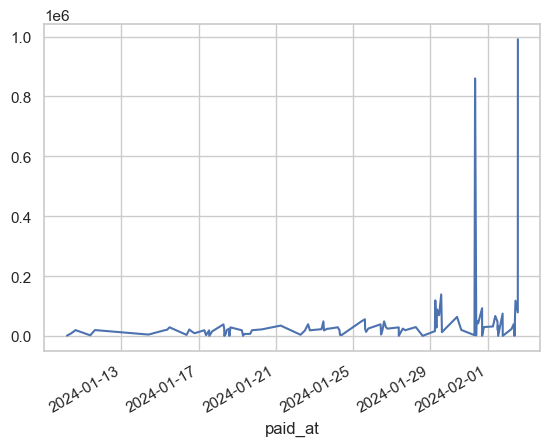

In [41]:
train_payment_data.query("loan_id == @loan_id").set_index("paid_at")['amount'].plot()

### test_loan_data.csv
- ~These are all the loans previously taken by the 2,000 customers?~
- Your goal is to use that data to build a model that would be able to predict the performance of 2,000 loans that are currently in Due Diligence (the test data).

In [42]:
test_loan_data = pd.read_csv(data_dir/"test_loan_data.csv")
test_loan_data.columns

Index(['loan_id', 'business_id', 'credit_officer_id', 'dismissal_description',
       'acquisition_channel', 'sector', 'principal', 'total_owing_at_issue',
       'application_number', 'applying_for_loan_number', 'loan_number',
       'employee_count', 'approval_status', 'payment_status', 'paid_late',
       'total_recovered_on_time', 'total_recovered_15_dpd',
       'cash_yield_15_dpd'],
      dtype='object')

In [43]:
test_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   2000 non-null   int64  
 1   business_id               2000 non-null   int64  
 2   credit_officer_id         2000 non-null   int64  
 3   dismissal_description     0 non-null      float64
 4   acquisition_channel       2000 non-null   object 
 5   sector                    2000 non-null   object 
 6   principal                 2000 non-null   float64
 7   total_owing_at_issue      2000 non-null   float64
 8   application_number        2000 non-null   int64  
 9   applying_for_loan_number  2000 non-null   int64  
 10  loan_number               2000 non-null   int64  
 11  employee_count            1613 non-null   float64
 12  approval_status           2000 non-null   object 
 13  payment_status            2000 non-null   object 
 14  paid_lat

# 🧹 | Task Formulation

- Customers that repay on-time are more likely to be retained which is good for our business
- It’s rare for us to relend to a customer that pays back more than 15 days late
- Ultimately, yield is one of our most important metrics

### Columns that are potential targets
- total_recovered_on_time
- paid_late
- total_recovered_15_dpd
- cash_yield_15_dpd
- total_recovered_on_time == total_recovered_15_dpd makes no sense, would have used the percentage paid on time and within 15 days as a definition of performance.

### Conclusion
- Practical: classification task use paid_late as the target and business, application details and payment history as input.
- Next steps: Good performance would be defined by total_recovered_on_time,  total_recovered_15_dpd, cash_yield_15_dpd all these would be percentages of what is expected at a certain time.
    - These predictions could then be used to answer the question of how much can Numida safely lend a business and less of whether a loan should be given or not.
    - Couldn't be done because the values of total_recovered_15_dpd for businesses that paid on time didn't make sense.
    - How long it took to repay a loan? Would make sense with the date the loan was taken?

In [44]:
np.setdiff1d(test_loan_data.columns, train_loan_data.columns)

array(['payment_status'], dtype=object)

In [45]:
# train_loan_data['on_time_to_15_dpd'] = train_loan_data['total_recovered_on_time'] / train_loan_data['total_recovered_15_dpd']

# ⚙️ | Training Data Extraction
- Business details
- Loan application details
- Repayment history
- Paid late (target)

In [46]:
# Identification variables.
id_variables = ['loan_id', 'business_id'] 

# Business detail variables.
business_detail_variables = ['sector', 'employee_count'] 

# Loan application variables.
loan_application_variables = ['principal', 'total_owing_at_issue', 'application_number', 'applying_for_loan_number', 'loan_number']

# How did the loan perform?
target = 'paid_late'

In [47]:
# Catch: There is no repayment history for the "current" loan, for each loan, use the previous loan repayment 

In [48]:
(train_loan_data['business_id'].value_counts() == 1).sum()

111

In [50]:
from train_utils.feature_engineering import preprocess_dataframe, extract_historical_loan_features, calculate_loan_repayment_features

In [51]:
historical_loan_features = extract_historical_loan_features(
    train_loan_data, 
    known_approval_statuses=['Approved', 'Declined', 'Cancelled', 'Expired']
)

In [55]:
# historical_loan_features